In [ ]:
!pip list

In [1]:
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import pandas as pd  
import rasterio as rio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rasterio.plot import show
import albumentations as A
from albumentations.pytorch import ToTensorV2
#import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

/cephyr/users/benvin/Alvis/.local/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /cephyr/users/benvin/Alvis/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


In [11]:
import sys
sys.path.insert(0, '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/geography-aware-ssl/moco_fmow/moco')
from ms_nl_resnet import MS_NL_ResNet18

import importlib

import fmow_dataloader
importlib.reload(fmow_dataloader)

train_csv = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/imagepathfull.csv"

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [3]:
encoder_k = MS_NL_ResNet18(num_classes=128, last_layer_activation = nn.ReLU())

dim_mlp = encoder_k.fc.weight.shape[1]
encoder_k.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), encoder_k.fc)

gpu = 0
#encoder_k.cuda(gpu)

#summary(encoder_k, (8, 224, 224))

In [8]:
CHECKPOINT_PATH = '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/geography-aware-ssl/moco_fmow/moco/checkpoints_imgnetpre/checkpoint_0069.pth.tar'
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=loc)

# Load key encoder into regular model, KEEP MLP LAYERS, need to define them before, see moco_builder 
# how it is done
encoder_k_state_dict = dict()
for key in checkpoint['state_dict'].keys():
    if "module.encoder_k" in key:
        resnet_key=key.replace("module.encoder_k.", "")
        #if "fc.2." in resnet_key:
        #    resnet_key = "module.fc." + resnet_key[12:]
        #    if "weight" in resnet_key:
        #        encoder_k_state_dict[resnet_key]=torch.Tensor(np.random.rand(1, 1024))
        #        continue
        #    elif "bias" in resnet_key:
        #        encoder_k_state_dict[resnet_key]=torch.Tensor(np.random.rand(1))
        #        continue
#
        #if "fc.0." in resnet_key:
            #continue
        encoder_k_state_dict[resnet_key]=checkpoint['state_dict'][key]

encoder_k.load_state_dict(encoder_k_state_dict)

<All keys matched successfully>

In [12]:
aug_a = A.Compose([
    #A.Resize(224, 224, )
    
    A.RandomResizedCrop(224, 224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    A.GaussianBlur(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
])

train_dataset = fmow_dataloader.CustomDatasetFromImagesTemporal(train_csv,
    transform=aug_a)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle = True)



<class 'list'>


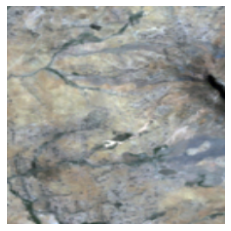

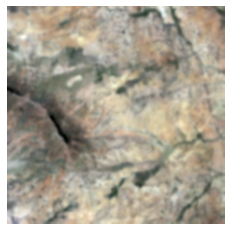

<AxesSubplot:>

In [65]:

for i, (images, labels) in enumerate(train_loader):
    print(type(images))
    
    #images[0] = images[0].cuda(gpu, non_blocking=True)
    #images[1] = images[1].cuda(gpu, non_blocking=True)
    output = encoder_k(images[0])
    
    
    break

#for image in images
plt.axis('off')
show(images[0][0].detach().numpy()[(2,1,0),:,:], adjust=True)
plt.axis('off')
show(images[1][0].detach().numpy()[(2,1,0),:,:], adjust=True)


In [68]:
print(output.size())
squeezed = torch.squeeze(output)
print(squeezed.size())
unsqueezed = torch.unsqueeze(squeezed, dim=0)
print(unsqueezed.size())

torch.Size([1, 128])
torch.Size([128])
torch.Size([1, 128])


In [13]:
def index_to_year(index):
    start_year = 1990 + index*3
    end_year = start_year + 2
    return str(start_year) + "-" + str(end_year)

(3,)
(3, 5, 128)
(15, 128)
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


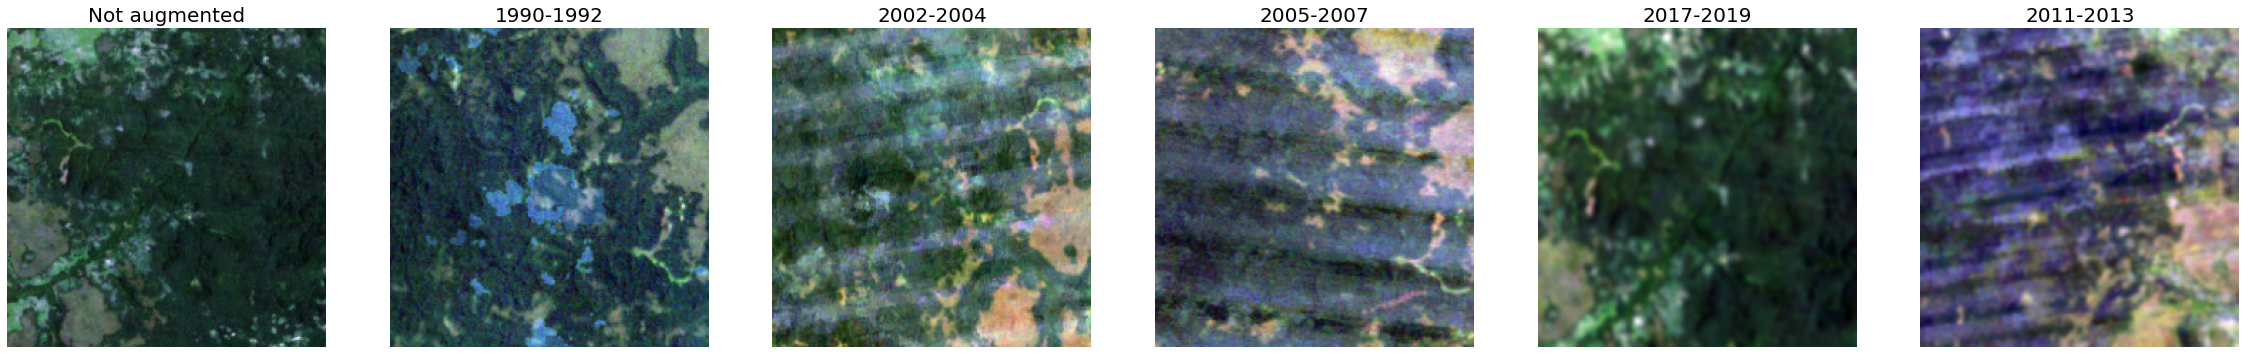

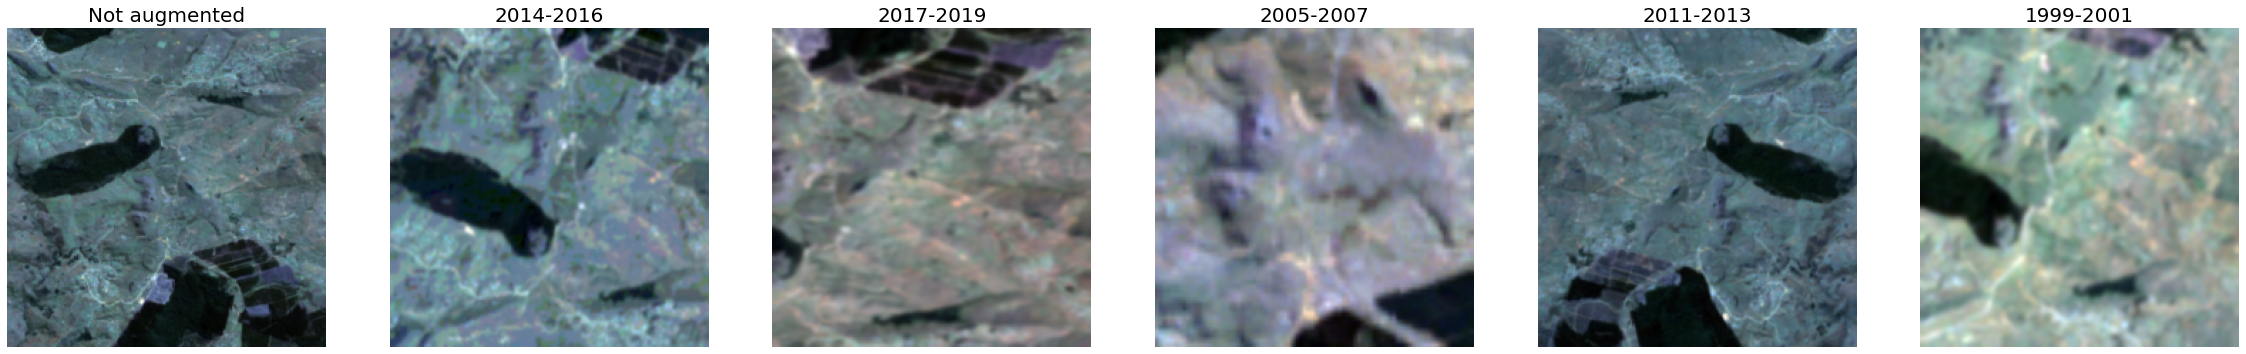

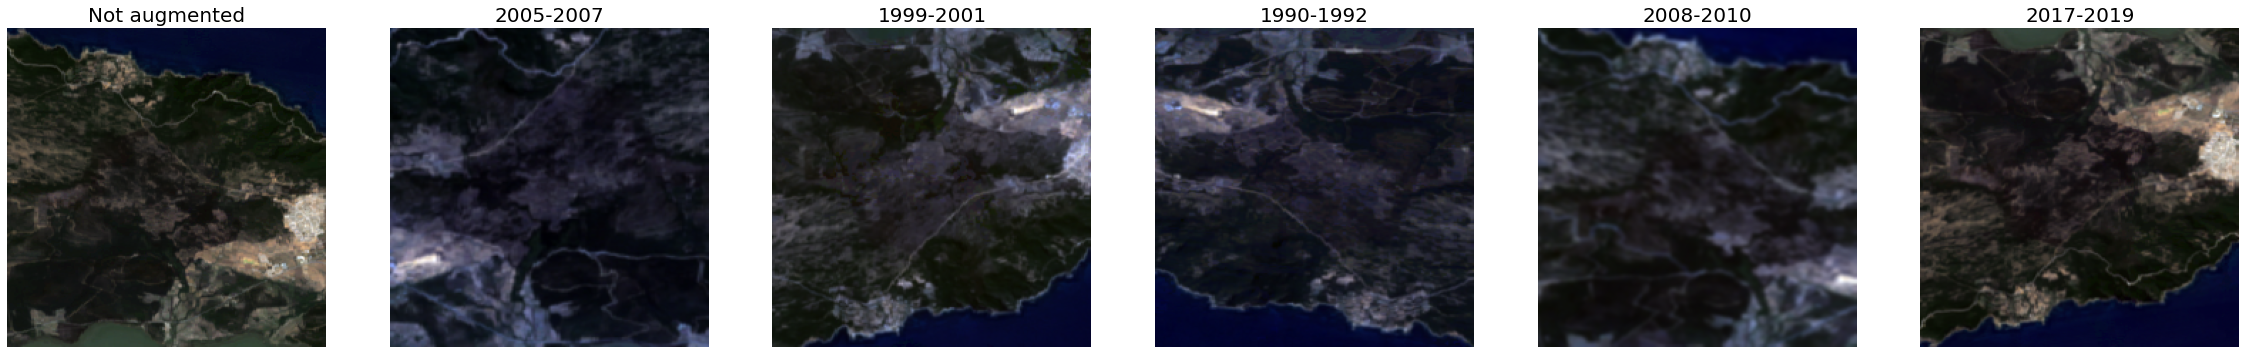

In [37]:
import random

n_images = 3
n_composites = 5

import pandas as pd
train_csv = pd.read_csv("/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/imagepathfull.csv", header=0)
train_csv_sample = train_csv.sample(n=n_images)#, random_state=42)

img_paths = train_csv_sample[train_csv_sample.columns[0]]
img_paths.to_list()
print(np.shape(img_paths))



outputs = np.zeros((n_images,n_composites,128))

for i, img_path in enumerate(img_paths):
    img_src = rio.open(img_path)
    img_numpy = img_src.read()
    rgb_last_image = [75,74,73]
    
    fig, axs = plt.subplots(1, n_composites + 1, figsize=(40,40))
    
    axs[0].axis('off')
    axs[0].set_title("Not augmented", fontsize=20)
    show(img_src.read(rgb_last_image), ax=axs[0], adjust=True)
    
    comp_indices = [x for x in range(10)]
    random.shuffle(comp_indices)
    
    for t in range(n_composites):
        
        comp_index = comp_indices[t]
        composite = img_numpy[8*comp_index : 8*comp_index+8]
        
        
        composite = np.transpose(composite, (1,2,0))
        composite = aug_a(image=composite)['image']
        
        axs[t+1].axis('off')
        axs[t+1].set_title(index_to_year(comp_indices[t]), fontsize=20)
        show(composite.numpy()[(2,1,0),:,:], ax=axs[t+1], adjust=True)
        
        # Add "batch dimension"
        composite = torch.unsqueeze(composite, dim=0)
        encoder_output = encoder_k(composite)
        encoder_output = torch.squeeze(encoder_output)
        outputs[i][t] = encoder_output.detach().numpy()
    
    
print(np.shape(outputs))
merged = outputs.reshape(-1,outputs.shape[2])
print(np.shape(merged))

# X_embedded = TSNE(n_components=3, learning_rate='auto',
#                   init='random').fit_transform(merged)
# X_embedded.shape

colors = [int(x/n_composites) for x in range(n_images*n_composites)]
print(colors)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


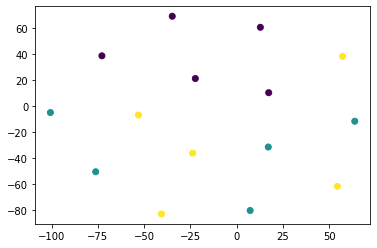

In [38]:

X_embedded_2d = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(merged)
X_embedded_2d.shape

print(colors)
plt.scatter(X_embedded_2d[:,0], X_embedded_2d[:,1], c=colors)

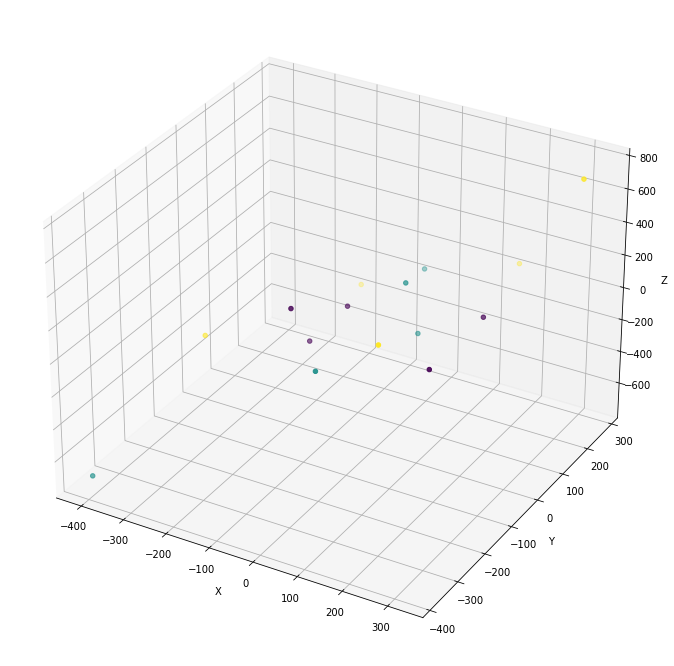

In [39]:
X_embedded_3d = TSNE(n_components=3, learning_rate='auto',
                  init='random').fit_transform(merged)
X_embedded_3d.shape

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_embedded_3d[:,0], X_embedded_3d[:,1], X_embedded_3d[:,2], c=colors)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()




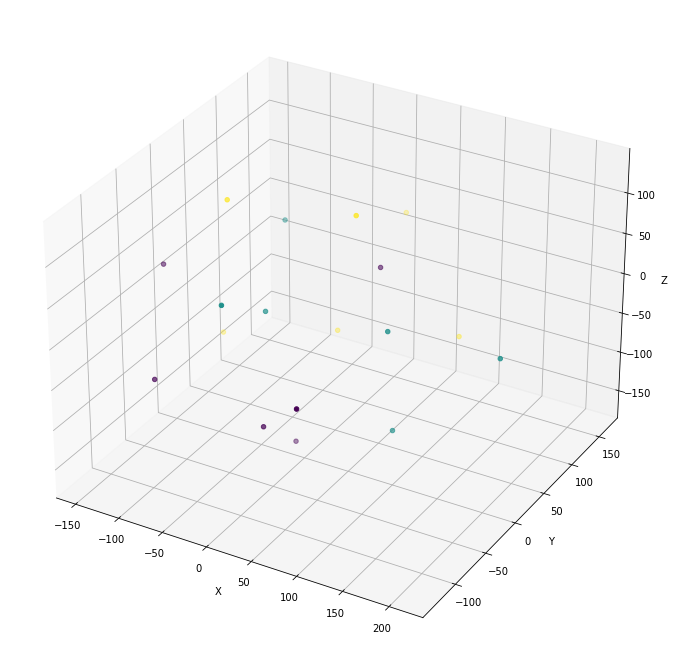

In [11]:
fig2 = plt.figure(figsize=(12, 12))
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(X_embedded_3d[:,1], X_embedded_3d[:,2], X_embedded_3d[:,0], c=colors)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.show()

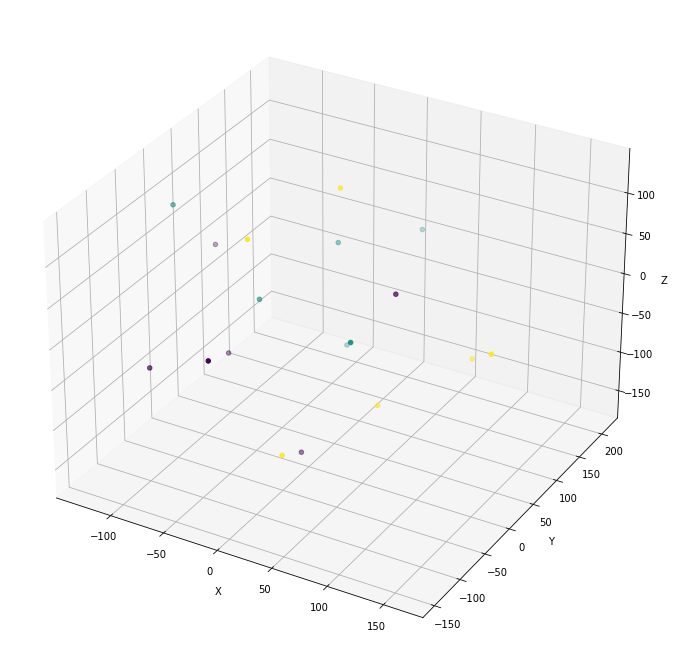

In [12]:
fig3 = plt.figure(figsize=(12, 12))
ax3 = fig3.add_subplot(projection='3d')
ax3.scatter(X_embedded_3d[:,2], X_embedded_3d[:,1], X_embedded_3d[:,0], c=colors)

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.show()

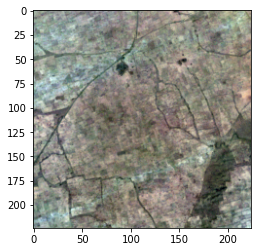

<AxesSubplot:>

In [217]:
img_src = rio.open(img_path)
img_numpy = img_src.read()
show(img_src.read(rgb_last_image), adjust=True)

(8, 224, 224)
(224, 224, 8)
torch.Size([8, 224, 224])


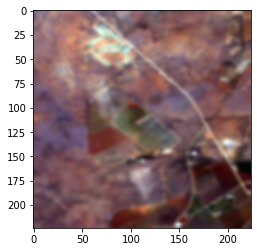

<AxesSubplot:>

In [199]:
composite = img_numpy[8*comp_index : 8*comp_index+8]

print(np.shape(composite))
#composite = torch.squeeze(composite)
composite = np.transpose(composite, (1,2,0))
print(np.shape(composite))
composite = aug_a(image=composite)['image']
print(np.shape(composite))
show(composite.numpy()[(2,1,0),:,:], adjust=True)